In [16]:
import pathlib
import tensorflow as tf
import os
import numpy as np
import shutil

def createDF(ext="*.input.npy", data = 'train'):
    def process_path(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        fname = tf.strings.join(parts[:-1], "/")
        fname = fname.numpy().decode('UTF-8') + "/" + parts[-1].numpy().decode('UTF-8')[:18]
        label = np.load(fname + "output.npy")
        label_flat = np.load(fname + "output_flat.npy")
        input_arr = np.load(file_path.numpy())
        fname = parts[-1]
        return fname, input_arr, label, label_flat
    
    if data == 'train':
        data_dir = pathlib.Path("./Training_Validation_Testing").with_suffix('')
    else:
        data_dir = pathlib.Path("./Holdout").with_suffix('')
    image_count = len(list(data_dir.glob(ext)))
    list_ds = tf.data.Dataset.list_files(str(data_dir/ext), shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
    ds_paths = list_ds
    print("Dataset length: %d" % tf.data.experimental.cardinality(ds_paths).numpy())

    ds = ds_paths.map(lambda paths: tf.py_function(process_path, 
                                                   inp=[paths], 
                                                   Tout=[tf.string, tf.float32, tf.float32, tf.float32]))

    savedir = "./dataset" if data == 'train' else "./holdout_dataset"
    tf.data.Dataset.save(ds, savedir)
    print("DB has been created")

    
def rnd_rmv(f,x,y,yf, window, version, num_cutouts, scale_factor):
    #fname = [int(i) for i in f.numpy().decode('UTF-8')[:-11]]
    fname = f.numpy().decode('UTF-8') + "_rnd" + str(window.numpy()) + "_v" + str(version.numpy())
    mask = tf.logical_or(tf.math.equal(x, 1.0), tf.math.equal(x, 0.5))
    arr = np.vstack((np.where(mask == True)[0], np.where(mask == True)[1])).T
    idxs = tf.range(tf.shape(arr)[0])
    ridxs = tf.random.shuffle(idxs)[:num_cutouts]#[:n]
    rinput = tf.gather(arr, ridxs)
    rinput = rinput.numpy()
    new_x = x.numpy()
    
    for i in range(num_cutouts):
        # Create a window around the chosen index and set the value of the cells to 0
        start_i = max(0, rinput[i, 0]-window)
        end_i = min(new_x.shape[0], rinput[i,0]+window)
        start_j = max(0, rinput[i, 1]-window)
        end_j = min(new_x.shape[1], rinput[i,1]+window)
        new_x[start_i:end_i, start_j:end_j] = 0
    
    return fname,new_x,y,yf



def split_and_augmentDF(window=10, num_cutouts = 1, repeats = 1, original_ds = True, scale_factor=1, splits=3):
    
    for s in range(splits):
        ds = tf.data.Dataset.load("./dataset")
        ds_size = int(ds.cardinality())
        train_size = int(0.79 * ds_size)
        val_size = int((ds_size - train_size)*0.4)
        test_size = ds_size - val_size - train_size
        ds = ds.shuffle(300, seed=s)
        if os.path.exists("./temp/"):
            shutil.rmtree("./temp/")
        ds.save("./temp/")
        ds = tf.data.Dataset.load("./temp/")
        train_dataset = ds.take(train_size)
        test_dataset = ds.skip(train_size).take(test_size)
        val_dataset = ds.skip(train_size+test_size)

        print("Training dataset length: %d" % tf.data.experimental.cardinality(train_dataset).numpy())
        print("Validation dataset length: %d" % tf.data.experimental.cardinality(val_dataset).numpy())
        print("Testing dataset length: %d" % tf.data.experimental.cardinality(test_dataset).numpy())
        
        print("Saving the test datasets ....")
        test_dataset.save("test_ds_split_%d" % (s+1))
        train_dataset.save("train_ds_split_%d" % (s+1))
        val_dataset.save("val_ds_split_%d" % (s+1))
        print("Done saving, proceeding to augmentation....")
        for k in range(2):
            temp_ds = train_dataset if k==0 else val_dataset
            dss = []
            if original_ds:
                dss.append(temp_ds)

            for i in range(repeats):
                print ("Augmented DB slice %d is in creation......." % i)
                ds_augmented = temp_ds.map(lambda f,x,y,yf: tf.py_function(rnd_rmv, 
                                                       inp=[f,x,y,yf,window, i, num_cutouts, scale_factor], 
                                                       Tout=[tf.string, tf.float32, tf.float32, tf.float32]))
                dss.append(ds_augmented)


            combined_dataset = dss[0]

            print ("Writing the augmented DB, please wait.......")

            for i in range(1, len(dss)):
                combined_dataset = combined_dataset.concatenate(dss[i])

            combined_dataset = combined_dataset.prefetch(tf.data.AUTOTUNE)
            ds_type = "train_ds_aug" if k==0 else "val_ds_aug"
            name = "%s_split_%d" % (ds_type, s+1)
            tf.data.Dataset.save(combined_dataset, name)
        print("Augmented DBs have been created")
    if os.path.exists("./temp/"):
        shutil.rmtree("./temp/")

In [17]:
createDF(ext="*.input.npy", data = 'train')
createDF(ext="*.input.npy", data = 'hold')
split_and_augmentDF(window=30, repeats = 19, original_ds = True, num_cutouts = 2, splits=3)

Dataset length: 142
DB has been created
Dataset length: 32
DB has been created
Training dataset length: 112
Validation dataset length: 12
Testing dataset length: 18
Saving the test datasets ....
Done saving, proceeding to augmentation....
Augmented DB slice 0 is in creation.......
Augmented DB slice 1 is in creation.......
Augmented DB slice 2 is in creation.......
Augmented DB slice 3 is in creation.......
Augmented DB slice 4 is in creation.......
Augmented DB slice 5 is in creation.......
Augmented DB slice 6 is in creation.......
Augmented DB slice 7 is in creation.......
Augmented DB slice 8 is in creation.......
Augmented DB slice 9 is in creation.......
Augmented DB slice 10 is in creation.......
Augmented DB slice 11 is in creation.......
Augmented DB slice 12 is in creation.......
Augmented DB slice 13 is in creation.......
Augmented DB slice 14 is in creation.......
Augmented DB slice 15 is in creation.......
Augmented DB slice 16 is in creation.......
Augmented DB slice 17 i

## Data Visualization

Dataset length: 18
Scenario: b'01000001101101101.input.npy'
Number of output coastal locations: 12066
Input shape: (1024, 1024)
Output shape: (1024, 1024) 
Input MinMax: 0.000000 1.000000
Output MinMax: 0.000000 6.126911 
Scenario: b'00000100000000000.input.npy'
Number of output coastal locations: 12066
Input shape: (1024, 1024)
Output shape: (1024, 1024) 
Input MinMax: 0.000000 1.000000
Output MinMax: 0.000000 6.125362 
Scenario: b'00010000000000000.input.npy'
Number of output coastal locations: 12066
Input shape: (1024, 1024)
Output shape: (1024, 1024) 
Input MinMax: 0.000000 1.000000
Output MinMax: 0.000000 6.124573 
Scenario: b'10100000000000000.input.npy'
Number of output coastal locations: 12066
Input shape: (1024, 1024)
Output shape: (1024, 1024) 
Input MinMax: 0.000000 1.000000
Output MinMax: 0.000000 5.667753 
Scenario: b'10111010110101111.input.npy'
Number of output coastal locations: 12066
Input shape: (1024, 1024)
Output shape: (1024, 1024) 
Input MinMax: 0.000000 1.000000


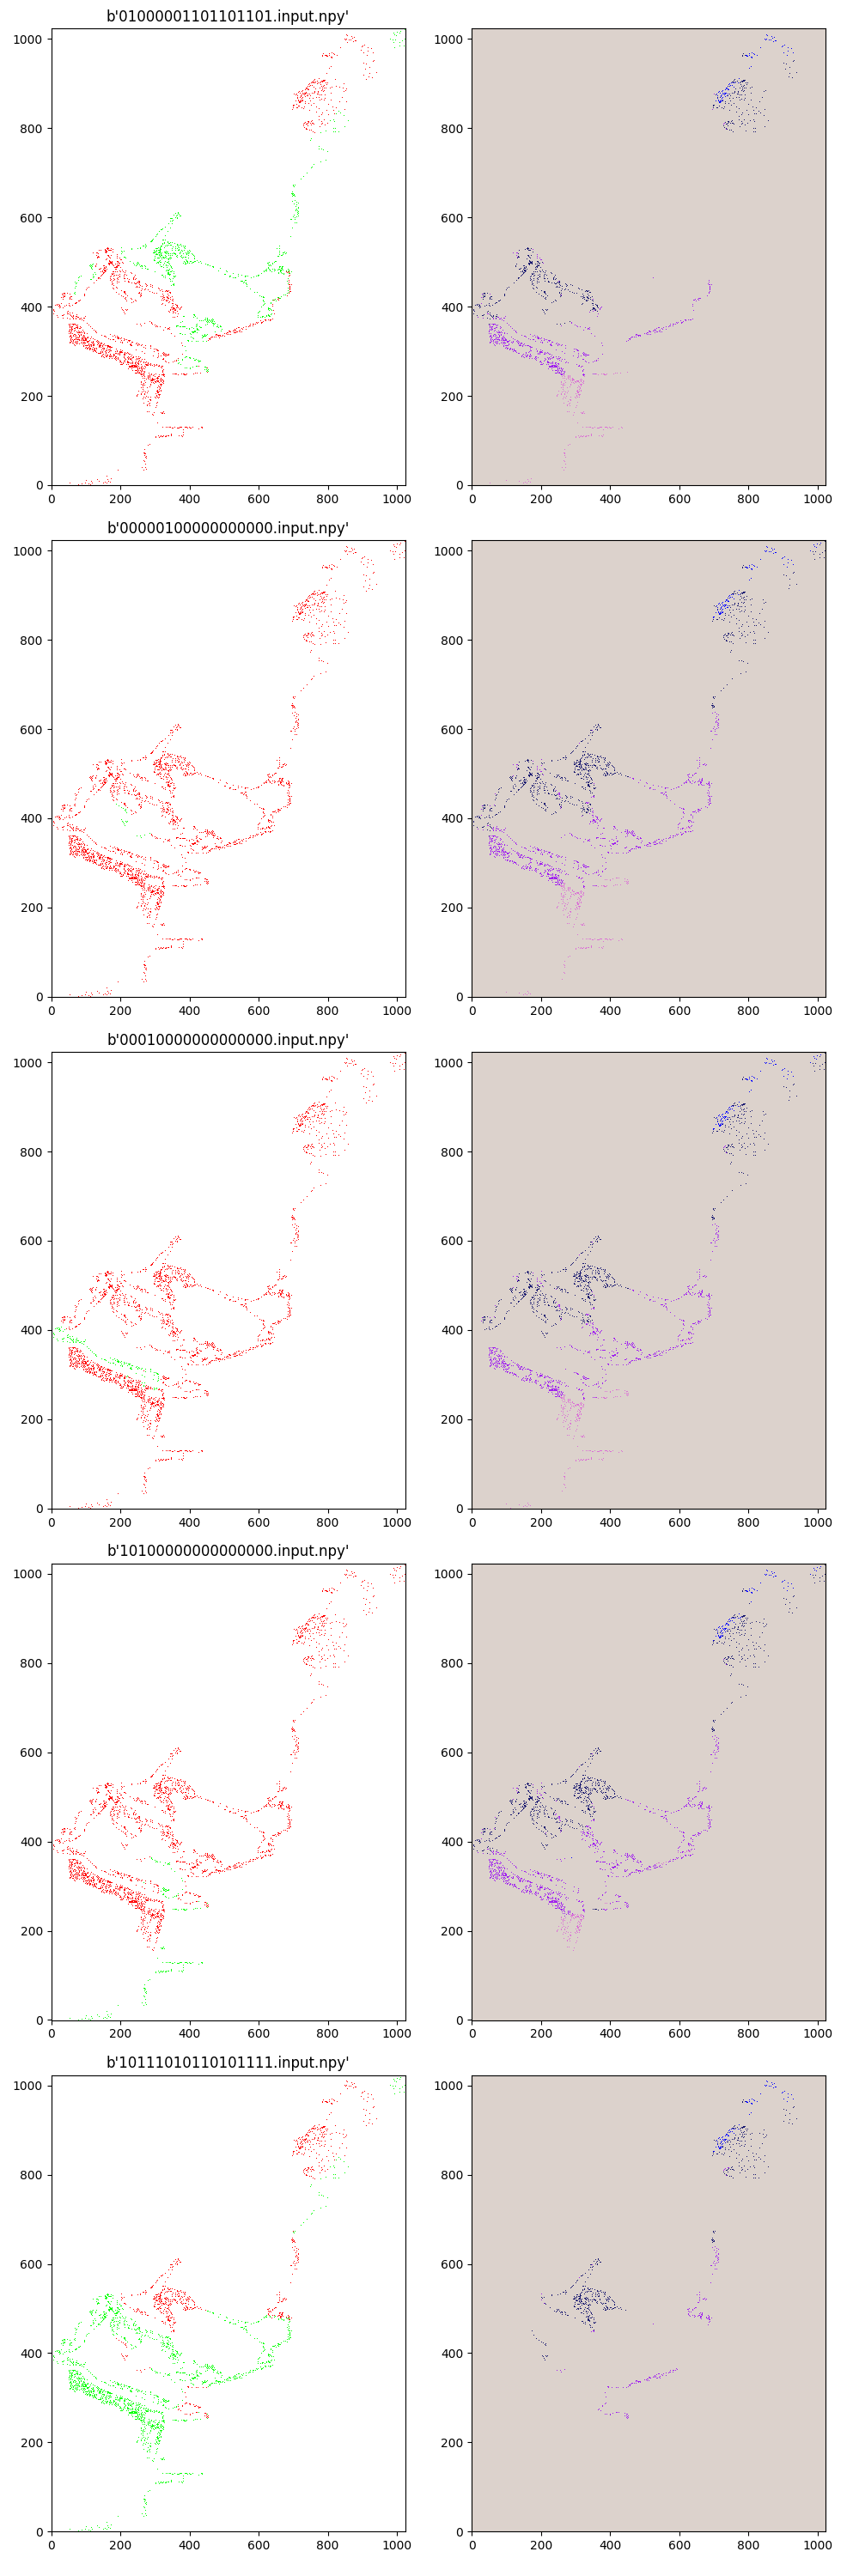

In [18]:
import sys
sys.path.insert(0, '../')
import matplotlib.pyplot as plt
from configs import *
%matplotlib widget

split = 2
batch_size = 10
ds_type = "test_ds" #"train_ds_aug" #"val_ds_aug" "test_ds"
name = "%s_split_%d" % (ds_type, split)
ds = tf.data.Dataset.load(name).prefetch(tf.data.AUTOTUNE)
print("Dataset length: %d" % tf.data.experimental.cardinality(ds).numpy())

plt.close()
fig, axs = plt.subplots(5,2, figsize=(10, 30), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .2, wspace=.13)
fig.tight_layout(pad=2, h_pad=2.5, w_pad=2.5)
axs = axs.ravel()

i = 0
for element in list(ds.as_numpy_iterator())[:5]: 
    scenario, input_map, output, output_flat = element
    axs[i].imshow(input_map, cmap=incmap, origin="lower", interpolation='none', aspect='auto')
    axs[i].set_title(scenario)
    i += 1
    axs[i].imshow(output, cmap=outcmap, norm=outnorm, origin="lower", interpolation='none', aspect='auto')
    i += 1
    print("Scenario: %s" % scenario)
    print("Number of output coastal locations: %d" % len(output_flat))
    print("Input shape: %s" % str(input_map.shape))
    print("Output shape: %s " % str(output.shape))
    print("Input MinMax: %f %f" % (input_map.min(), input_map.max()))
    print("Output MinMax: %f %f " % (output.min(), output.max()))

In [19]:
import sys
sys.path.insert(0, '../')
from utils import *
split = 2

dss = tf.data.Dataset.load("./holdout_dataset")
for element in list(dss.as_numpy_iterator()): 
    scenario, input_map, output, output_flat = element
    print (scenario.decode("utf-8"))

00000001111110000.input.npy
11111110000000111.input.npy
11110001111000111.input.npy
00001111111110000.input.npy
00111111111111100.input.npy
10101010101010101.input.npy
00011100011100011.input.npy
00110011001100110.input.npy
11001100110011001.input.npy
00011000110001100.input.npy
11111000011111000.input.npy
11111110000001111.input.npy
00000001111111000.input.npy
11110000111100001.input.npy
00000011111000000.input.npy
11100011100011100.input.npy
00001110000111000.input.npy
11100111001110011.input.npy
11111100000111111.input.npy
11111100000011111.input.npy
00001111000011110.input.npy
00000111111100000.input.npy
00000111100000111.input.npy
00000011111100000.input.npy
11111000000011111.input.npy
00000111110000011.input.npy
00011111111111000.input.npy
11100000000000111.input.npy
11110000000001111.input.npy
01010101010101010.input.npy
11000000000000011.input.npy
11111000001111100.input.npy
